In [1]:
%matplotlib inline
from __future__ import print_function, unicode_literals
import sys, os
import json
import math
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import pandas as pd
import numpy as np
from shapely.geometry import box

In [2]:
from pygaarst import raster
sys.path.append("../firedetection/")
import viirsswathtools as vst
import viirsifire as vif
import viirstools as vt

In [3]:
R = 6367 # earth radius in km

def haversine(lon1, lat1, lon2, lat2):
    """
    Approx. calc of the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    dist_km = R * c
    return dist_km 

In [4]:
ALT1 = True
ALT2 = False 
basedir = '/Volumes/cwdata1/VIIRS/GINA/dds.gina.alaska.edu/NPP/viirs/'
outdir = '/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/rasterout/'
if ALT1:
    basedir = '/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/VIIRS/'
elif ALT2:
    basedir = '/Volumes/SCIENCE/Fire/DATA_BY_AREA/2015/VIIRS/'

if os.path.isdir(basedir):
    print(basedir, "exists")
else:
    print("Please check directory {}: cannot access it.".format(basedir))

/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/VIIRS/ exists


In [5]:
sns.set(rc={'image.cmap': 'magma'})
sns.set_context("poster", font_scale=1.6)
earth='cornsilk'
water='lightskyblue'

In [6]:
granulecatalogfn = 'viirsgranulecatalog_in_ROI.json'
with open(os.path.join(basedir, granulecatalogfn), 'rU') as src:
    granuledir = json.load(src)
granuleDF = pd.DataFrame.from_dict(granuledir, orient='index')
testgranule = granuleDF.loc[u'20150615_2309183']

In [7]:
testscene04 = raster.VIIRSHDF5(os.path.join(testgranule['dir'], testgranule['SVI04']))
testscene05 = raster.VIIRSHDF5(os.path.join(testgranule['dir'], testgranule['SVI05']))
pixelq4 = testscene04.pixelquality
pixelq5 = testscene05.pixelquality

In [8]:
datestamp = vt.getdatestamp_AKDT(testscene04)

In [9]:
sockeye_lon, sockeye_lat = (-150.08544, 61.84486)
imin, imax, jmin, jmax = testscene04.crop(sockeye_lat, sockeye_lon, 50, 50)

In [10]:
skips = vst.get_skips(testscene04, imin, imax, jmin, jmax)
skiprows = vst.get_badrows(skips)

In [11]:
scene = testscene04
bandname = scene.bandname
testdat = scene.dataobj['All_Data'][bandname]['BrightnessTemperature'][imin:imax, jmin:jmax]
mult, add = scene.dataobj['All_Data'][bandname]['BrightnessTemperatureFactors'][:]
testdat = testdat*mult + add
plotraster4 = np.delete(testdat, skiprows, 0)

In [12]:
scene = testscene05
bandname = scene.bandname
testdat = scene.dataobj['All_Data'][bandname]['BrightnessTemperature'][imin:imax, jmin:jmax]
mult, add = scene.dataobj['All_Data'][bandname]['BrightnessTemperatureFactors'][:]
testdat = testdat*mult + add
plotraster5 = np.delete(testdat, skiprows, 0)

In [13]:
pixq4 = pixelq4[imin:imax, jmin:jmax]
pixq4 = np.delete(pixq4, skiprows, 0)
pixq5 = pixelq5[imin:imax, jmin:jmax]
pixq5 = np.delete(pixq5, skiprows, 0)

In [14]:
lons = np.delete(scene.lons[imin:imax, jmin:jmax], skiprows, 0)
lats = np.delete(scene.lats[imin:imax, jmin:jmax], skiprows, 0)

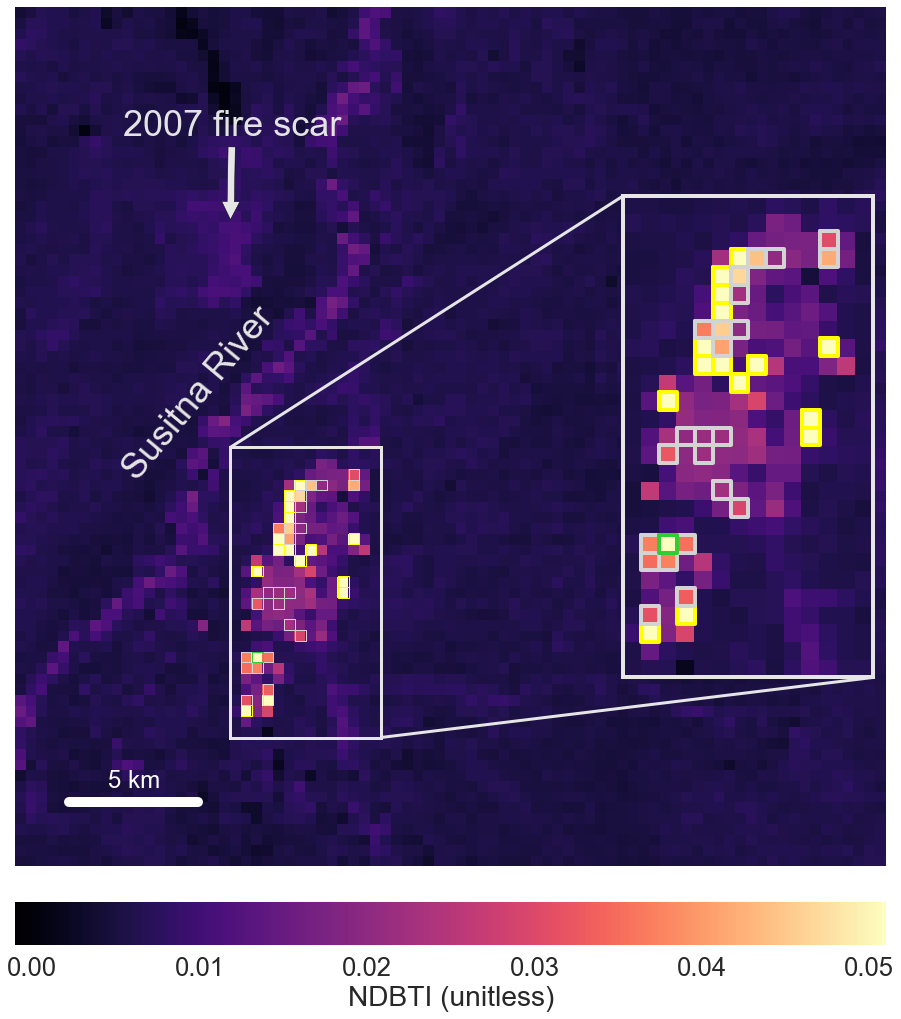

In [30]:
plotraster45 =  (plotraster4 - plotraster5) / (plotraster4 + plotraster5)

titlestr1 = "Willow study area: NDBTI"

anomalouscondition, hotcondition, warmcondition = vif.getfireconditions_fromrasters(
        plotraster4, plotraster5, pixq4, pixq5) 

plotraster45_masked = np.ma.masked_where(
    ~hotcondition, np.ones(plotraster45.shape))
plotraster_cool = np.ma.masked_where(
    ~warmcondition, np.ones(plotraster45.shape))
plotraster45_anomalousmasked = np.ma.masked_where(
    ~anomalouscondition, np.ones(plotraster45.shape))

cmap1 = matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'chartreuse']))
cmap2 = matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'yellow orange']))
cmap3 = matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'kelly green']))

plottitle = '{}, {}\n VIFDAHL high intensity: yellow, low intensity: orange, saturated: green'.format(
    titlestr1, datestamp)

fig1 = plt.figure(1, figsize=(15, 15))
ax1 = fig1.add_subplot(111)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.grid(False)

dataplot = ax1.pcolormesh(np.fliplr(plotraster45), vmin=-.001, vmax=0.051)   
cbarlabel = "NDBTI (unitless)"

#############
x1, x2, y1, y2 = 40, 54, 12, 39
axins1 = zoomed_inset_axes(ax1, 1.66, loc=5)
dataplot = axins1.pcolormesh(np.fliplr(plotraster45), vmin=-.001, vmax=0.051)   
#dataplot3 = axins1.pcolormesh(np.fliplr(plotraster_cool), cmap=cmap2, vmin=0, vmax=1)
#dataplot2 = axins1.pcolormesh(np.fliplr(plotraster45_masked), cmap=cmap1, vmin=0, vmax=1)
#dataplot4 = axins1.pcolormesh(np.fliplr(plotraster45_anomalousmasked), cmap=cmap3, vmin=0, vmax=1)
iis, jjs =  np.where(np.fliplr(hotcondition))
for ii, jj in zip(iis, jjs):
    y, x = box(ii, jj, ii+1, jj+1).boundary.xy
    axins1.plot(x, y, color='yellow', linewidth=4, zorder=5)
    ax1.plot(x, y, color='yellow', linewidth=1, zorder=5)
iis, jjs =  np.where(np.fliplr(warmcondition))
for ii, jj in zip(iis, jjs):
    y, x = box(ii, jj, ii+1, jj+1).boundary.xy
    axins1.plot(x, y, color='lightgrey', linewidth=4, zorder=5)
    ax1.plot(x, y, color='lightgrey', linewidth=1, zorder=5)
iis, jjs =  np.where(np.fliplr(anomalouscondition))
for ii, jj in zip(iis, jjs):
    y, x = box(ii, jj, ii+1, jj+1).boundary.xy
    axins1.plot(x, y, color='limegreen', linewidth=4, zorder=5)
    ax1.plot(x, y, color='limegreen', linewidth=1, zorder=5)

    
axins1.set_xlim((x1, x2))
axins1.set_ylim((y1, y2))
axins1.set_xticklabels([])
axins1.set_yticklabels([])
mark_inset(ax1, axins1, loc1=2, loc2=4, fc='none', ec='0.9', lw=3)
############
for axis in ['top', 'bottom', 'left', 'right']:
    axins1.spines[axis].set_color('0.9')
    axins1.spines[axis].set_linewidth(4)


#ax1.set_title(plottitle)
ax1.set_aspect('equal')
ax1.set_xlim(20, plotraster45.shape[1])
ax1.set_ylim(0, plotraster45.shape[0])


ax1.annotate("2007 fire scar",
            xy=(40, 60), xycoords='data',
            xytext=(30, 68), textcoords='data',
            zorder=10,
            color='0.9',
            size=36,
            arrowprops=dict(arrowstyle="simple",
                            fc='0.9',
                            connectionstyle="arc3"))

ax1.text(37, 44, "Susitna River", 
         ha="center", va="center", 
         rotation=50, color="0.9",
         size=36)
ax1.plot([25, 37], [6, 6], lw=10, color='w')
ax1.text(31, 8, "5 km", 
         ha="center", va="center", 
         color="w",
         size=24)

plt.tight_layout()

divider = make_axes_locatable(ax1)
cax = divider.append_axes("bottom", size='5%', pad=0.5)
cbar = plt.colorbar(dataplot, orientation='horizontal', cax=cax, ticks=[0.0, 0.01, 0.02, 0.03, 0.04, 0.05])
cbar.set_label(cbarlabel)

plt.subplots_adjust(bottom=0.1)


In [33]:
pixq4.shape

(1515, 6400)

In [100]:
ii = 6
startj = 25
endj = 37
lat1 = np.fliplr(lats)[ii, startj]
lat2 = np.fliplr(lats)[ii, endj]
lon1 = np.fliplr(lons)[ii, startj]
lon2 = np.fliplr(lons)[ii, endj]
print(lat1, lat2, lon1, lon2)

61.7065 61.713 -150.236 -150.143


In [101]:
haversine(lon1, lat1, lon2, lat2)

4.99407252020793

In [31]:
fn = 'Fig03.png'
fig1.savefig(os.path.join(outdir, fn), bb_inches='tight', dpi=300)
fn = 'Fig03_LR.png'
fig1.savefig(os.path.join(outdir, fn), bb_inches='tight', dpi=150)

In [32]:
from PIL import Image
from io import BytesIO

In [33]:
fn = 'Fig03'
png = Image.open(os.path.join(outdir, fn + '.png'))
png.save(os.path.join(outdir, fn + '.tif'))
png.close()